# Stroll SRL Test

Test the eScience tool [Stroll](https://github.com/Filter-Bubble/stroll) for semantic role labeling of Dutch

In the test, we attempted to use Stroll for the tasks described in the paper [Digital story grammar: a quantitative methodology for narrative analysis](https://www.tandfonline.com/doi/abs/10.1080/13645579.2020.1723205) by Stefan Bastholm Andrade and Ditte Andersen

Note: the AllenNLP software can be used for processing English text, see https://allennlp.org/ and notebook [allennlp-tests.ipynb](https://github.com/navigating-stories/notebooks/blob/main/allennlp-tests.ipynb) in this directory

In [3]:
import os
import pandas as pd
import re
import stanza
import stroll.stanza
from IPython.display import clear_output

In [4]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

## 1. SRL analysis functions

Steps for analyzing letters with `analyze_letter`:

1. Read text of letters with `read_file`
1. Get NLP analysis from Stanza with `run_nlp`
1. Convert NLP analysis to table with `nlp_analysis_to_table`
1. Correct head attachments for verb "zijn" ("be") with `correct_attachments_table`
1. Perform SRL analysis on NLP tabl with `nlp_table_to_srl_table`

In [5]:
def analyze_letter(letter_id):
    text = read_file(letter_id)
    nlp_analysis = run_nlp(text)
    nlp_table_df = nlp_analysis_to_table(nlp_analysis)
    nlp_table_df = correct_attachments_table(nlp_table_df)
    srl_table_df = nlp_table_to_srl_table(nlp_table_df)
    return text, nlp_table_df, srl_table_df

In [6]:
FILE_DIR = "../letters/"

def read_file(in_file_id):
    try:
        in_file = open(f"{FILE_DIR}{in_file_id}.txt", "r")
    except:
        sys.exit(f"cannot open {FILE_DIR}{in_file_id}.txt")
    text = ""
    for line in in_file:
        text += line.strip() + " "
    in_file.close()
    return text.strip()

In [7]:
run_nlp = stanza.Pipeline(lang='nl', processors='tokenize,lemma,pos,depparse,srl')

2022-02-15 11:32:07 INFO: Loading these models for language: nl (Dutch):
| Processor | Package |
-----------------------
| tokenize  | alpino  |
| pos       | alpino  |
| lemma     | alpino  |
| depparse  | alpino  |
| srl       | default |

2022-02-15 11:32:07 INFO: Use device: cpu
2022-02-15 11:32:07 INFO: Loading: tokenize
2022-02-15 11:32:07 INFO: Loading: pos
2022-02-15 11:32:08 INFO: Loading: lemma
2022-02-15 11:32:08 INFO: Loading: depparse
2022-02-15 11:32:08 INFO: Loading: srl
2022-02-15 11:32:12 INFO: Done loading processors!


In [8]:
def nlp_analysis_to_table(nlp_analysis):
    nbr_of_words = 0
    for s in nlp_analysis.sentences:
        for w in s.words:
            if nbr_of_words == 0:
                nlp_table_df = pd.DataFrame({"id": [w.id], 
                                             "text": [w.text], 
                                             "lemma": [w.lemma],
                                             "upos": [w.upos],
                                             "xpos": [w.xpos],
                                             "feats": [w.feats],
                                             "head": [w.head],
                                             "deprel": [w.deprel],
                                             "deps": [w.deps],
                                             "misc": [w.misc],
                                             "start_char": [w.start_char],
                                             "end_char": [w.end_char],
                                             "parent": [w.parent],
                                             "sent": [w.sent],
                                             "srl": [w.srl],
                                             "frame": [w.frame],
                                            })
            else:
                nlp_table_df.loc[len(nlp_table_df.index)] = [ w.id, w.text, w.lemma, w.upos, w.xpos, w.feats, 
                                                              w.head, w.deprel, w.deps, w.misc, w.start_char, w.end_char, 
                                                              w.parent, w.sent, w.srl, w.frame, ]
            nbr_of_words += 1
    return nlp_table_df

In [9]:
SRL_FIELDS = [ "sent_id", "head_id", "head", "nsubj", "rel", "Arg0", "Arg1", "Arg2", 
               "ArgM-ADV", "ArgM-CAU", "ArgM-DIS", "ArgM-LOC", "ArgM-MNR", "ArgM-MOD", "ArgM-NEG", "ArgM-REC", "ArgM-TMP", ]


def srl_dict_to_srl_list(srl_dict, nlp_dict):
    srl_list = len(SRL_FIELDS) * [ "" ]
    for i in range(0, len(SRL_FIELDS)):
        if SRL_FIELDS[i] in srl_dict:
            srl_list[i] = srl_dict[SRL_FIELDS[i]]
        if SRL_FIELDS[i] in nlp_dict:
            srl_list[i] = nlp_dict[SRL_FIELDS[i]]
    return srl_list

In [10]:
def add_srl_data_to_srl_table(srl_table_df, srl_data, nlp_data, sentence):
    print(srl_data)
    for phrase_key in srl_data:
        if 'head' in srl_data[phrase_key]:
            srl_data[phrase_key]["head"] += " " + sentence[phrase_key]
        elif phrase_key > 0:
            srl_data[phrase_key]["head"] = sentence[phrase_key]
        else:
            srl_data[phrase_key]["head"] = "FILLER"
        if phrase_key in nlp_data:
            srl_table_df.loc[len(srl_table_df)] = srl_dict_to_srl_list(srl_data[phrase_key], nlp_data[phrase_key])
        else:
            srl_table_df.loc[len(srl_table_df)] = srl_dict_to_srl_list(srl_data[phrase_key], {})

In [11]:
def swap_aux_head(sentence_df, child, head, heads_head):
    for i in range(0, len(sentence_df)):
        if sentence_df.at[i, "id"] == head:
            sentence_df.at[i, "head"] = child
        elif sentence_df.at[i, "id"] == child:
            sentence_df.at[i, "head"] = heads_head
        elif sentence_df.at[i, "head"] == head:
            sentence_df.at[i, "head"] = child
    return sentence_df

In [12]:
def correct_attachments_sentence(sentence_df):
    children = {}
    xpos = {}
    upos = {}
    text = {}
    heads = {}
    for i, row in sentence_df.iterrows():
        child = row["id"]
        head = row["head"]
        if head not in children:
            children[head] = []
        children[head].append(child)
        xpos[child] = row["xpos"]
        upos[child] = row["upos"]
        text[child] = row["text"]
        heads[child] = head
    for head in children:
        if head != 0 and not re.search("^WW", xpos[head]):
            for child in children[head]:
                if re.search("^WW", xpos[child]) and upos[child] == "AUX":
                    sentence_df = swap_aux_head(sentence_df, child, head, heads[head])
    return sentence_df

In [13]:
def correct_attachments_table(nlp_table_df):
    sentence_df = pd.DataFrame([])
    nlp_table_df_out = pd.DataFrame([])
    last_id = -1
    for i, row in nlp_table_df.iterrows():
        if row["id"] < last_id:
            new_sentence_df = correct_attachments_sentence(sentence_df)
            if len(nlp_table_df_out) == 0:
                nlp_table_df_out = new_sentence_df
            else:
                nlp_table_df_out = pd.concat([nlp_table_df_out, new_sentence_df])
            sentence_df = pd.DataFrame([])
        sentence_df = sentence_df.append(pd.DataFrame([row]), ignore_index = True)
        last_id = row["id"]
    if len(sentence_df) > 0:
        new_sentence_df = correct_attachments_sentence(sentence_df)
        if len(nlp_table_df_out) == 0:
            nlp_table_df_out = new_sentence_df
        else:
            nlp_table_df_out = pd.concat([nlp_table_df_out, new_sentence_df])
    return nlp_table_df_out

In [14]:
def nlp_table_to_srl_table(nlp_table_df):
    srl_table_df = pd.DataFrame({ field: [] for field in SRL_FIELDS })
    srl_data = {}
    nlp_data = {}
    sentence = {}
    last_id = 0
    sent_id = 1
    for i, row in nlp_table_df.iterrows():
        if row['id'] <= last_id:
            if len(srl_data) > 0:
                add_srl_data_to_srl_table(srl_table_df, srl_data, nlp_data, sentence)
            sent_id += 1
            srl_data = {}
            nlp_data = {}
            sentence = {}
        if row['srl'] != "_":
            if row['head'] not in srl_data:
                srl_data[row['head']] = { "sent_id": sent_id, "head_id": row["head"] }
            if row['srl'] in srl_data[row['head']]:
                print(f"duplicate role for {row['srl']} [{i}]: {srl_data[row['head']][row['srl']]} and {row['lemma']}")
                srl_data[row['head']][row['srl']] += " " + row['lemma']
            else:
                srl_data[row['head']][row['srl']] = row['lemma']
        if row['frame'] == "rel":
            if row['id'] not in srl_data:
                srl_data[row['id']] = { "sent_id": sent_id, "head_id": row["id"] }
            if row['frame'] not in srl_data[row['id']]:
                srl_data[row['id']][row['frame']] = row['lemma']
            else:
                srl_data[row['id']][row['frame']] += " " + row['lemma']
        if row['deprel'] == "nsubj":
            if row['head'] not in nlp_data:
                nlp_data[row['head']] = { "sent_id": sent_id, "head_id": row["head"] }
            if 'nsubj' in nlp_data[row['head']]:
                nlp_data[row['head']]["nsubj"] += " " + row['lemma']
            else:
                nlp_data[row['head']]["nsubj"] = row['lemma']
        if row['deprel'] == "compound:prt":
            if row['head'] not in nlp_data:
                nlp_data[row['head']] = { "sent_id": sent_id, "head_id": row["head"] }
            if 'head' in nlp_data[row['head']]:
                nlp_data[row['head']]["head"] += " " + row['lemma']
            else:
                nlp_data[row['head']]["head"] = row['lemma']
        last_id = row['id']
        sentence[row['id']] = row['lemma'] 
    if len(srl_data) > 0:
        add_srl_data_to_srl_table(srl_table_df, srl_data, nlp_data, sentence)
    return srl_table_df

## 2. SRL application to text

Source of Dutch pandemic letters: https://www.utwente.nl/en/bms/ehealth/research/story-lab/post-corona%20Futures/Letters/Nederlands/

Short texts: 10 and 18
    
Long texts: 14 and 17

In [15]:
text, nlp_table_df, srl_table_df = analyze_letter(10)

/home/erikt/projects/navigatingstories/env/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/home/erikt/projects/navigatingstories/env/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: DGLGraph.__len__ is deprecated.Please directly call DGLGraph.number_of_nodes.
  return warnings.warn(message, category=category, stacklevel=1)


{11: {'sent_id': 2, 'head_id': 11, 'Arg1': 'ik', 'Arg2': 'tijd_machine', 'rel': 'gaan'}}
{2: {'sent_id': 3, 'head_id': 2, 'ArgM-TMP': 'toekomst'}, 14: {'sent_id': 3, 'head_id': 14, 'Arg2': 'anders'}}
{2: {'sent_id': 4, 'head_id': 2, 'Arg1': 'technologie'}}
{7: {'sent_id': 5, 'head_id': 7, 'rel': 'rijden', 'Arg1': 'auto'}}
{10: {'sent_id': 6, 'head_id': 10, 'ArgM-ADV': 'wennen'}}
{2: {'sent_id': 7, 'head_id': 2, 'Arg0': 'auto', 'rel': 'rijden', 'ArgM-LOC': 'water', 'ArgM-ADV': 'benzine'}, 13: {'sent_id': 7, 'head_id': 13, 'ArgM-TMP': 'vroeg'}}
{3: {'sent_id': 8, 'head_id': 3, 'Arg0': 'stad'}, 10: {'sent_id': 8, 'head_id': 10, 'Arg0': 'mens', 'rel': 'hebben', 'Arg1': 'contact', 'ArgM-REC': 'elkaar'}}
duplicate role for ArgM-CAU [10]: corona and daarom
{9: {'sent_id': 9, 'head_id': 9, 'ArgM-CAU': 'corona daarom', 'rel': 'trekken', 'Arg0': 'mens', 'ArgM-ADV': 'veel', 'ArgM-REC': 'elkaar'}}
duplicate role for Arg1 [3]: toekomst and er
{3: {'sent_id': 10, 'head_id': 3, 'Arg1': 'toekomst er',

In [16]:
text

'Vrolijk en schoon Mijn naam is J. en ik ben in een tijdmachine gegaan. Het is 40 jaar later in de toekomst en het is zo anders geworden. Er is veel meer technologie en het is vrolijker geworden. De straten zijn drukker, er rijden meer auto’s. Maar het zijn andere auto’s dan wat ik gewend ben. Auto’s rijden op schoon water in plaats van benzine wat vroeger zo was. De stad lijkt gezelliger geworden dan vroeger en mensen hebben meer contact met elkaar. Sinds de corona virus van 40 jaar geleden trekken mensen daarom meer met elkaar op. Mijn toekomst ziet er goed uit, ik heb een gezin met 3 kinderen. Ik woon in Amsterdam en heb een erg mooie huis. Ik ben zakenman geworden en heb aardig wat geld opgespaard. Ik wil al dit geld uiteindelijk gaan geven aan mn kinderen, ze zijn namelijk alles voor mij. Ik ben ook erg goed met mijn familie, we zien elkaar elke week minimaal 3x. Zoon, deze brief is voor jou en ik wil jou nog heel veel succes wensen met je leven. Maak er het beste van jongen!'

In [17]:
srl_table_df

,sent_id,head_id,head,nsubj,rel,Arg0,Arg1,Arg2,ArgM-ADV,ArgM-CAU,ArgM-DIS,ArgM-LOC,ArgM-MNR,ArgM-MOD,ArgM-NEG,ArgM-REC,ArgM-TMP
0,2.0,11.0,gaan,ik,gaan,,ik,tijd_machine,,,,,,,,,
1,3.0,2.0,zijn,het,,,,,,,,,,,,,toekomst
2,3.0,14.0,worden,het,,,,anders,,,,,,,,,
3,4.0,2.0,zijn,technologie,,,technologie,,,,,,,,,,
4,5.0,7.0,rijden,auto,rijden,,auto,,,,,,,,,,
5,6.0,10.0,zijn,ik,,,,,wennen,,,,,,,,
6,7.0,2.0,rijden,auto,rijden,auto,,,benzine,,,water,,,,,
7,7.0,13.0,zijn,wat,,,,,,,,,,,,,vroeg
8,8.0,3.0,lijken,stad,,stad,,,,,,,,,,,
9,8.0,10.0,hebben,mens,hebben,mens,contact,,,,,,,,,elkaar,


In [19]:
nlp_table_df[90:110]

,id,text,lemma,upos,xpos,feats,head,deprel,deps,misc,start_char,end_char,parent,sent,srl,frame
14,15,.,.,PUNCT,LET,None,3,punct,None,None,452,453,"[\n {\n ""id"": 15,\n ""text"": ""."",\n ""...","[\n {\n ""id"": 1,\n ""text"": ""De"",\n ""...",_,_
0,1,Sinds,sinds,ADP,VZ|init,None,4,case,None,None,454,459,"[\n {\n ""id"": 1,\n ""text"": ""Sinds"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Sinds"",\n ...",_,_
1,2,de,de,DET,LID|bep|stan|rest,Definite=Def,4,det,None,None,460,462,"[\n {\n ""id"": 2,\n ""text"": ""de"",\n ""...","[\n {\n ""id"": 1,\n ""text"": ""Sinds"",\n ...",_,_
2,3,corona,corona,NOUN,N|soort|ev|basis|zijd|stan,Gender=Com|Number=Sing,9,obl,None,None,463,469,"[\n {\n ""id"": 3,\n ""text"": ""corona"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Sinds"",\n ...",ArgM-CAU,_
3,4,virus,virus,NOUN,N|soort|ev|basis|onz|stan,Gender=Neut|Number=Sing,3,appos,None,None,470,475,"[\n {\n ""id"": 4,\n ""text"": ""virus"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Sinds"",\n ...",_,_
4,5,van,van,ADP,VZ|init,None,8,case,None,None,476,479,"[\n {\n ""id"": 5,\n ""text"": ""van"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Sinds"",\n ...",_,_
5,6,40,40,NUM,TW|hoofd|prenom|stan,None,7,nummod,None,None,480,482,"[\n {\n ""id"": 6,\n ""text"": ""40"",\n ""...","[\n {\n ""id"": 1,\n ""text"": ""Sinds"",\n ...",_,_
6,7,jaar,jaar,NOUN,N|soort|ev|basis|onz|stan,Gender=Neut|Number=Sing,8,nmod,None,None,483,487,"[\n {\n ""id"": 7,\n ""text"": ""jaar"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Sinds"",\n ...",_,_
7,8,geleden,geleden,ADV,BW,None,4,nmod,None,None,488,495,"[\n {\n ""id"": 8,\n ""text"": ""geleden"",\n...","[\n {\n ""id"": 1,\n ""text"": ""Sinds"",\n ...",_,_
8,9,trekken,trekken,VERB,WW|pv|tgw|mv,Number=Plur|Tense=Pres|VerbForm=Fin,0,root,None,None,496,503,"[\n {\n ""id"": 9,\n ""text"": ""trekken"",\n...","[\n {\n ""id"": 1,\n ""text"": ""Sinds"",\n ...",_,rel


## 3. Who, where, when, what, why and how?

The six questions were proposed by Roberto Franzosi, On quantitative narrative analysis. In: J.A. Holstein & J.F. Gubrium, Varieties of narative analysys, London: Sage, 2012.

In [21]:
def show_results(results_dict):
    results_df = pd.DataFrame([{ "key": key, "count": results_dict[key], "best value": ""} 
                               for key in sorted(results_dict, key=lambda k: results_dict[k], reverse=True)])
    best_keys = get_best_keys(results_df)
    for i, row in results_df.iterrows():
        if row["key"] in best_keys:
            results_df.at[i, "best value"] = "yes"
    return results_df

The best keys are those with the highest counts. If several keys have the same highest counts, preference is given to those staring with a capital character.

In [22]:
def get_best_keys(results_df):
    best_count = -1
    best_keys = []
    for i, row in results_df.iterrows():
        if row["count"] > best_count:
            best_count = row["count"]
            best_keys = [row["key"]]
        elif row["count"] == best_count:
            best_keys.append(row["key"])
    case_is_upper = []
    for key in best_keys:
        case_is_upper.append(re.search(r"^[A-Z]", key) != None)
    if True in case_is_upper:
        best_keys = [ best_keys[i] for i in range(0, len(best_keys)) if case_is_upper[i] ] 
    return best_keys

In [44]:
def get_actors(srl_table_df):
    actors = {}
    for i, row in srl_table_df.iterrows():
        if row["Arg0"] != "":
            actor = row["Arg0"]
        elif row["nsubj"] != "":
            actor = row["nsubj"]
        else:
            actor = ""
        if actor != "":
            if actor in actors:
                actors[actor] += 1
            else:
                actors[actor] = 1
    return actors

In [24]:
def get_locations(srl_table_df):
    locations = {}
    for i, row in srl_table_df.iterrows():
        if row["ArgM-LOC"] != "":
            location = row["ArgM-LOC"]
        else:
            location = ""
        if location != "":
            if location in locations:
                locations[location] += 1
            else:
                locations[location] = 1
    return locations

In [25]:
def get_times(srl_table_df):
    times = {}
    for i, row in srl_table_df.iterrows():
        if row["ArgM-TMP"] != "":
            time = row["ArgM-TMP"]
        else:
            time = ""
        if time != "":
            if time in times:
                times[time] += 1
            else:
                times[time] = 1
    return times

In [26]:
def get_causes(srl_table_df):
    causes = {}
    for i, row in srl_table_df.iterrows():
        if row["ArgM-CAU"] != "":
            cause = row["ArgM-CAU"]
        else:
            cause = ""
        if cause != "":
            if cause in causes:
                causes[cause] += 1
            else:
                causes[cause] = 1
    return causes

In [27]:
def get_manners(srl_table_df):
    manners = {}
    for i, row in srl_table_df.iterrows():
        if row["ArgM-MNR"] != "":
            manner = row["ArgM-MNR"]
        else:
            manner = ""
        if manner != "":
            if manner in manners:
                manners[manner] += 1
            else:
                manners[manner] = 1
    return manners

In [28]:
def get_actions(srl_table_df):
    actions = {}
    for i, row in srl_table_df.iterrows():
        if row["rel"] != "":
            action = row["rel"]
        elif row["head"] != "":
            action = row["head"]
        else:
            action = ""
        if action != "":
            if action in actions:
                actions[action] += 1
            else:
                actions[action] = 1
    return actions

In [31]:
show_results(get_actors(srl_table_df)).loc[:5,]

,key,count,best value
0,ik,8,yes
1,het,2,
2,auto,2,
3,mens,2,
4,technologie,1,
5,wat,1,


In [32]:
show_results(get_locations(srl_table_df)).loc[:5,]

,key,count,best value
0,water,1,
1,Amsterdam,1,yes


In [33]:
show_results(get_times(srl_table_df)).loc[:5,]

,key,count,best value
0,toekomst,1,yes
1,vroeg,1,yes
2,uiteindelijk,1,yes
3,week,1,yes
4,nog,1,yes


In [34]:
show_results(get_manners(srl_table_df)).loc[:5,]

,key,count,best value
0,goed,1,yes
1,aardig,1,yes
2,minimaal,1,yes


In [35]:
show_results(get_causes(srl_table_df)).loc[:5,]

,key,count,best value
0,corona daarom,1,yes


In [36]:
show_results(get_actions(srl_table_df)).loc[:5,]

,key,count,best value
0,zijn,6,yes
1,hebben,3,
2,worden,2,
3,rijden,2,
4,zien,2,
5,willen,2,


## 4. Subject, verb, object

Analysis based on dependency relation but the quality of these seems to be quite low

In [37]:
sent_data = {}
last_token_id = -1
for i, row in nlp_table_df.iterrows():
    if row["id"] < last_token_id:
        if len(sent_data) > 0:
            print(sent_data)
            sent_data = {}
    last_token_id = row["id"]
    for rel in [ "conj", "obj", "root", "subj"]:
        if re.search(rel, row["deprel"]):
            if rel == "root" or rel == "conj":
                head = row["id"]
            else:
                head = row["head"]
            if head not in sent_data:
                sent_data[head] = {}
            if rel in sent_data[head]:
                sent_data[head][rel] += " " + row["lemma"]
            else:
                sent_data[head][rel] = row["lemma"]
if len(sent_data) > 0:
    print(sent_data)

{1: {'root': 'vrolijk'}, 3: {'conj': 'schoon'}}
{3: {'subj': 'naam'}, 4: {'root': 'J.'}, 11: {'subj': 'ik', 'conj': 'gaan'}}
{2: {'subj': 'het'}, 5: {'root': 'laat'}, 14: {'subj': 'het', 'conj': 'worden'}}
{2: {'root': 'zijn', 'subj': 'technologie'}, 10: {'subj': 'het', 'conj': 'worden'}}
{3: {'subj': 'straat'}, 4: {'root': 'druk'}, 7: {'subj': 'auto'}}
{3: {'subj': 'het'}, 5: {'root': 'auto'}, 10: {'obj': 'wat', 'subj': 'ik'}}
{2: {'subj': 'auto', 'root': 'rijden'}, 13: {'subj': 'wat'}}
{3: {'subj': 'stad', 'root': 'lijken'}, 10: {'subj': 'mens', 'conj': 'hebben', 'obj': 'contact'}}
{9: {'root': 'trekken', 'subj': 'mens'}}
{3: {'subj': 'toekomst', 'root': 'zien'}, 9: {'subj': 'ik', 'obj': 'gezin'}}
{2: {'subj': 'ik', 'root': 'wonen'}, 6: {'conj': 'hebben', 'obj': 'huis'}}
{4: {'subj': 'ik', 'root': 'worden'}, 10: {'obj': 'geld', 'conj': 'op_sparen'}}
{2: {'subj': 'ik', 'root': 'willen'}, 8: {'obj': 'geld'}, 14: {'subj': 'ze'}}
{2: {'subj': 'ik'}, 5: {'root': 'goed'}, 11: {'subj': 'we'

In [38]:
nlp_table_df[133:147]

,id,text,lemma,upos,xpos,feats,head,deprel,deps,misc,start_char,end_char,parent,sent,srl,frame
0,1,Ik,ik,PRON,VNW|pers|pron|nomin|vol|1|ev,Case=Nom|Person=1|PronType=Prs,4,nsubj,None,None,651,653,"[\n {\n ""id"": 1,\n ""text"": ""Ik"",\n ""...","[\n {\n ""id"": 1,\n ""text"": ""Ik"",\n ""...",Arg1,_
1,2,ben,zijn,AUX,WW|pv|tgw|ev,Number=Sing|Tense=Pres|VerbForm=Fin,4,aux,None,None,654,657,"[\n {\n ""id"": 2,\n ""text"": ""ben"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Ik"",\n ""...",_,_
2,3,zakenman,zakenman,NOUN,N|soort|ev|basis|zijd|stan,Gender=Com|Number=Sing,4,xcomp,None,None,658,666,"[\n {\n ""id"": 3,\n ""text"": ""zakenman"",\...","[\n {\n ""id"": 1,\n ""text"": ""Ik"",\n ""...",_,_
3,4,geworden,worden,VERB,WW|vd|vrij|zonder,VerbForm=Part,0,root,None,None,667,675,"[\n {\n ""id"": 4,\n ""text"": ""geworden"",\...","[\n {\n ""id"": 1,\n ""text"": ""Ik"",\n ""...",_,_
4,5,en,en,CCONJ,VG|neven,None,10,cc,None,None,676,678,"[\n {\n ""id"": 5,\n ""text"": ""en"",\n ""...","[\n {\n ""id"": 1,\n ""text"": ""Ik"",\n ""...",_,_
5,6,heb,hebben,AUX,WW|pv|tgw|ev,Number=Sing|Tense=Pres|VerbForm=Fin,10,aux,None,None,679,682,"[\n {\n ""id"": 6,\n ""text"": ""heb"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Ik"",\n ""...",_,_
6,7,aardig,aardig,ADJ,ADJ|vrij|basis|zonder,Degree=Pos,10,advmod,None,None,683,689,"[\n {\n ""id"": 7,\n ""text"": ""aardig"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Ik"",\n ""...",ArgM-MNR,_
7,8,wat,wat,DET,VNW|onbep|pron|stan|vol|3o|ev,None,9,det,None,None,690,693,"[\n {\n ""id"": 8,\n ""text"": ""wat"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Ik"",\n ""...",_,_
8,9,geld,geld,NOUN,N|soort|ev|basis|onz|stan,Gender=Neut|Number=Sing,10,obj,None,None,694,698,"[\n {\n ""id"": 9,\n ""text"": ""geld"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Ik"",\n ""...",Arg1,_
9,10,opgespaard,op_sparen,VERB,WW|vd|vrij|zonder,VerbForm=Part,4,conj,None,None,699,709,"[\n {\n ""id"": 10,\n ""text"": ""opgespaard...","[\n {\n ""id"": 1,\n ""text"": ""Ik"",\n ""...",_,rel


## 5. Analyze all letters

In [13]:
file_names = sorted(os.listdir(FILE_DIR))

all_srl_data = pd.DataFrame([])
all_nlp_data = pd.DataFrame([])
letter_lengths = []
for file_name in file_names:
    if re.search(r"\.txt$", file_name):
        letter_id = re.sub(r"\.txt$", "", file_name)
        squeal(letter_id)
        text, nlp_table_df, srl_table_df = analyze_letter(letter_id)
        all_srl_data = pd.concat([all_srl_data, srl_table_df])
        all_nlp_data = pd.concat([all_nlp_data, nlp_table_df])
        letter_lengths.append((len(srl_table_df), len(nlp_table_df)))

21


/home/erikt/projects/navigatingstories/env/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/home/erikt/projects/navigatingstories/env/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


duplicate role for Arg1 [21]: dat and inzicht
{16: {'sent_id': 2, 'head_id': 16, 'Arg1': 'één-en-twintiger', 'rel': 'besluiten', 'Arg0': 'groep'}, 30: {'sent_id': 2, 'head_id': 30, 'Arg1': 'dat inzicht', 'ArgM-NEG': 'nooit', 'ArgM-MOD': 'mogen', 'rel': 'gaan'}}
duplicate role for ArgM-TMP [6]: al and 2021
duplicate role for ArgM-ADV [8]: hen and 21-questions-day
{3: {'sent_id': 4, 'head_id': 3, 'ArgM-ADV': 'hen 21-questions-day', 'rel': 'vieren', 'Arg0': 'we', 'ArgM-TMP': 'al 2021'}}
duplicate role for Arg1 [8]: hiervoor and hart
{4: {'sent_id': 5, 'head_id': 4, 'Arg0': 'jij'}, 10: {'sent_id': 5, 'head_id': 10, 'Arg0': 'jij', 'Arg1': 'hiervoor hart', 'rel': 'uit_nodigen'}}
duplicate role for ArgM-TMP [7]: dag and 13:00
{4: {'sent_id': 6, 'head_id': 4, 'ArgM-TMP': 'dag 13:00', 'rel': 'komen', 'Arg1': '21ers'}}
{15: {'sent_id': 7, 'head_id': 15, 'ArgM-REC': 'elkaar', 'ArgM-MNR': 'ronde', 'Arg1': 'vraag', 'rel': 'stellen'}, 18: {'sent_id': 7, 'head_id': 18, 'rel': 'beantwoorden'}}
duplica

In [14]:
len(all_nlp_data), len(all_srl_data), sum([x[1] for x in letter_lengths]), sum([x[0] for x in letter_lengths])

(14596, 1820, 14596, 1820)

In [46]:
show_results(get_actions(all_srl_data)).loc[:5,]

,key,count,best value
0,zijn,207,yes
1,gaan,106,
2,hebben,80,
3,komen,67,
4,doen,50,
5,zien,38,


In [45]:
show_results(get_actors(all_srl_data)).loc[:5,]

,key,count,best value
0,we,191,yes
1,ik,166,
2,je,65,
3,het,60,
4,mens,59,
5,die,50,


In [49]:
show_results(get_times(all_srl_data)).loc[:5,]

,key,count,best value
0,nu,42,yes
1,weer,26,
2,steeds,17,
3,jaar,16,
4,nog,16,
5,tijd,10,


In [47]:
show_results(get_manners(all_srl_data)).loc[:5,]

,key,count,best value
0,hoe,21,yes
1,goed,14,
2,langzaam,10,
3,anders,9,
4,gewoon,8,
5,snel,6,


In [50]:
show_results(get_locations(all_srl_data)).loc[:5,]

,key,count,best value
0,waar,16,yes
1,waarin,14,
2,leven,8,
3,hier,8,
4,daar,6,
5,thuis,6,


In [48]:
show_results(get_causes(all_srl_data)).loc[:5,]

,key,count,best value
0,daardoor,8,yes
1,waarom,4,
2,daarom,3,
3,gaan,2,
4,hebben,2,
5,er,2,


In [16]:
all_nlp_data

,id,text,lemma,upos,xpos,feats,head,deprel,deps,misc,start_char,end_char,parent,sent,srl,frame
0,1,Brief,brief,NOUN,N|soort|ev|basis|zijd|stan,Gender=Com|Number=Sing,0,root,None,None,0,5,"[\n {\n ""id"": 1,\n ""text"": ""Brief"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Brief"",\n ...",_,_
1,2,aan,aan,ADP,VZ|init,None,4,case,None,None,6,9,"[\n {\n ""id"": 2,\n ""text"": ""aan"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Brief"",\n ...",_,_
2,3,het,het,DET,LID|bep|stan|evon,Definite=Def,4,det,None,None,10,13,"[\n {\n ""id"": 3,\n ""text"": ""het"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Brief"",\n ...",_,_
3,4,verleden,verleden,NOUN,N|soort|ev|basis|onz|stan,Gender=Neut|Number=Sing,1,nmod,None,None,14,22,"[\n {\n ""id"": 4,\n ""text"": ""verleden"",\...","[\n {\n ""id"": 1,\n ""text"": ""Brief"",\n ...",_,_
4,5,Hallo,Hallo,PROPN,N|eigen|ev|basis|zijd|stan,Number=Sing,6,amod,None,None,23,28,"[\n {\n ""id"": 5,\n ""text"": ""Hallo"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Brief"",\n ...",_,_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,17,zonder,zonder,ADP,VZ|init,None,19,case,None,None,5212,5218,"[\n {\n ""id"": 17,\n ""text"": ""zonder"",\n...","[\n {\n ""id"": 1,\n ""text"": ""Het"",\n ...",_,_
17,18,échte,echt,ADJ,ADJ|prenom|basis|met-e|stan,Degree=Pos,19,amod,None,None,5219,5224,"[\n {\n ""id"": 18,\n ""text"": ""échte"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Het"",\n ...",_,_
18,19,vragen,vraag,NOUN,N|soort|mv|basis,Number=Plur,20,obl,None,None,5225,5231,"[\n {\n ""id"": 19,\n ""text"": ""vragen"",\n...","[\n {\n ""id"": 1,\n ""text"": ""Het"",\n ...",ArgM-MNR,_
19,20,kan,kunnen,AUX,WW|pv|tgw|ev,Number=Sing|Tense=Pres|VerbForm=Fin,8,ccomp,None,None,5232,5235,"[\n {\n ""id"": 20,\n ""text"": ""kan"",\n ...","[\n {\n ""id"": 1,\n ""text"": ""Het"",\n ...",ArgM-MOD,_


## 6. Word frequencies

We compare the frequencies of the words "I" ("ik") and "we" ("we" and "wij") in the tekst. The frequencies are divided in five classes: "we" is much more (>5) of somewhat (2-5) more frequent than "I" (++we and +we), "I" is much more (>5) of somewhat (2-5) more frequent than "we" (++I and +I) and the rest (===).

In [34]:
class dict_class:
    def __init__(self, init_dict={}):
        self.data = dict(init_dict)
        
    def add(self, key, value=1):
        if key not in self.data:
            self.data[key] = value
        else:
            self.data[key] += value
            
    def get(self, key):
        return self.data[key]
    
    def get_all(self):
        return self.data

In [15]:
def compare_we(freq_i, freq_we):
    if freq_i >= 5 * freq_we:
        return "++I"
    elif freq_i >= 2 * freq_we:
        return "+I"
    if freq_we >= 5 * freq_i:
        return "++we"
    elif freq_we >= 2 * freq_i:
        return "+we"
    else:
        return("===")

In [35]:
counters = { "word": 0, "I": 0, "the": 0, "me": 0 , "we": 0, "our": 0 }
last_id = 0
text_id = 1
word_id = 0
I_vs_we = dict_class()
print("txt words ....I ...me ...we ..our Ivswe")
for i, row in list(all_nlp_data.iterrows()):
    if word_id >= letter_lengths[text_id-1][1]:
        freq_i = counters['I']/counters['word']
        freq_we = counters['we']/counters['word']
        print(f"{text_id:3} {letter_lengths[text_id-1][1]:5} {freq_i:0.3f} {counters['me']/counters['word']:0.3f} " +
               f"{freq_we:0.3f} {counters['our']/counters['word']:0.3f} {compare_we(freq_i, freq_we):4}")
        I_vs_we.add(compare_we(freq_i, freq_we))
        counters = { "word": 0, "I": 0, "the": 0, "me": 0, "we": 0, "our": 0 }
        text_id += 1
        word_id = 0
    word_id += 1
    last_id = row.name
    counters["word"] += 1
    if row["lemma"] == "ik":
        counters["I"] += 1
    if row["lemma"] == "de":
        counters["the"] += 1
    if row["lemma"] == "me" or row["lemma"] == "mij":
        counters["me"] += 1
    if row["lemma"] == "we" or row["lemma"] == "wij":
        counters["we"] += 1
    if row["lemma"] == "ons" or row["lemma"] == "onze":
        counters["our"] += 1

if counters["word"] > 0:
    freq_i = counters['I']/counters['word']
    freq_we = counters['we']/counters['word']
    print(f"{text_id:3} {letter_lengths[text_id-1][1]:5} {freq_i:0.3f} {counters['me']/counters['word']:0.3f} " +
           f"{freq_we:0.3f} {counters['our']/counters['word']:0.3f} {compare_we(freq_i, freq_we):4}")
    I_vs_we.add(compare_we(freq_i, freq_we))

txt words ....I ...me ...we ..our Ivswe
  1   274 0.033 0.011 0.000 0.000 ++I 
  2   438 0.009 0.005 0.034 0.005 +we 
  3  1091 0.016 0.002 0.012 0.005 === 
  4   735 0.005 0.000 0.041 0.018 ++we
  5   542 0.006 0.000 0.026 0.002 +we 
  6   328 0.003 0.000 0.018 0.000 ++we
  7  1189 0.011 0.002 0.005 0.002 +I  
  8   676 0.010 0.004 0.019 0.007 === 
  9   433 0.016 0.000 0.002 0.002 ++I 
 10   207 0.039 0.005 0.005 0.000 ++I 
 11  1014 0.001 0.000 0.012 0.004 ++we
 12   392 0.026 0.000 0.013 0.000 +I  
 13   347 0.023 0.009 0.003 0.003 ++I 
 14  1669 0.022 0.003 0.010 0.006 +I  
 15   559 0.007 0.002 0.004 0.000 +I  
 16  1250 0.002 0.000 0.018 0.006 ++we
 17  1478 0.028 0.003 0.011 0.006 +I  
 18   198 0.015 0.000 0.015 0.000 === 
 19   437 0.016 0.000 0.034 0.021 +we 
 20   400 0.015 0.000 0.043 0.025 +we 
 21   939 0.000 0.000 0.004 0.000 ++we


In [36]:
I_vs_we.get_all()

{'++I': 4, '+we': 4, '===': 3, '++we': 5, '+I': 5}

## 7. Domains of experience

In [67]:
import pandas as pd
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
# based on Andrade & Andersen, JSRM 2020, theory from Halliday 2004

VERB_CLASSES = {
    # sensing: four groups of verbs
    "verbal": [ "antwoorden", "beschrijven", "beloven", "noemen", "praten", "vertellen", "zeggen" ],
    "mental": [ "bedoelen", "begrijpen", "besluiten", "betrekken", "concluderen", "denken", "kennen", "laten", "over_gaan", "vergeten", "verwachten", "weten" ],
    "emotional": [ "bewonderen", "hopen", "missen", "vrezen" ],
    "visual": [ "bekijken", "kijken", "merken", "vinden", "zien" ],
    # doing: two groups of verbs
    "material": [ "doen", "door_gaan", "door_werken", "gaan", "houden", "kunnen", "lopen", "mediteren", "nemen", 
                  "plukken", "reizen", "schrijven", "varen", "voelen", "werken", "zitten" ],
    "expressional": [ "beslissen", "ervaren", "kiezen", "leren", "organiseren", "ontwerpen", "toe_staan" ],
    # being: two groups of verbs
    "existensional": [ "blijven", "horen", "komen", "leven", "mee_maken", "op_groeien", "op_lopen", "pensiëneren", "plaats_vinden", "staan", "sterven", "stoppen", 
                       "verdwijnen", "wennen", "willen", "wonen", "worden", "zijn"],
    "relational": [ "delen", "geven", "hebben", "krijgen", "moeten", "raken", "trouwen", "verliezen" ],
}

In [69]:
def plot_radar_chart(labels, values, title=""):
    angles = [ i* 2 * pi / len(labels) for i in range(0, len(labels)+1) ]
    labels.append("")
    values.append(values[0])
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles, labels)
    ax.plot(angles, values)
    ax.fill(angles, values, 'teal', alpha=0.1)
    ax.set_title(title)
    plt.show()

In [70]:
def get_first_person_verbs(srl_table_df):
    first_person_verbs = []
    for i, row in srl_table_df.iterrows():
        if row["Arg0"] == "ik" or row["nsubj"] == "ik":
            if row["rel"] != "":
                first_person_verbs.append(row["rel"])
            elif row["head"] != "":
                first_person_verbs.append(row["head"])
    return first_person_verbs

In [71]:
def classify_verbs(verbs):
    classified_verbs = { key: 0 for key in VERB_CLASSES }
    missed_verbs = []
    for verb in verbs:
        found = False
        for key in VERB_CLASSES:
            if verb in VERB_CLASSES[key]:
                classified_verbs[key] += 1
                found = True
                break
        if not found and verb not in missed_verbs:
            missed_verbs.append(verb)
            print(f"unknown verb: {verb}")
    return classified_verbs

In [78]:
verbs = get_first_person_verbs(all_srl_data)
classified_verbs = classify_verbs(verbs)

unknown verb: Koos


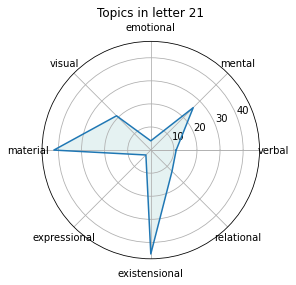

In [79]:
plot_radar_chart(list(classified_verbs.keys()), list(classified_verbs.values()), title=f"Topics in letter {letter_id}")

In [80]:
classified_verbs

{'verbal': 11,
 'mental': 26,
 'emotional': 4,
 'visual': 21,
 'material': 42,
 'expressional': 3,
 'existensional': 45,
 'relational': 13}

## 8. Suggestions for future work

1. Semantic Role Labeling is verb-based. Can we extract other information from the linguistic analysis that is non-verb-based?
1. Semantic Role Labeling is sentence-based. How do we obtain paragraph-based or story-based analysis?
1. The narrative topic analysis is interesting. We should expand the list of relevant verbs (and it should be checked).
1. LIWC analysis is quite similar to narraive topic analysis. It would be interesting to apply LIWC to our data.
1. Text comprehension work in the computational linguistics field looks similar to this work. It involves testing systems with QA tasks.
1. Summarization in combination with text entailment could also be useful for extracting ideas and concepts from the texts.
1. Co-reference resolution can be used for finding out who are referred to with pronouns.